**FROM KAGGLE**

***https://www.kaggle.com/datasets/ealaxi/paysim1***

This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler


C:\Users\Ryan Slattery\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Ryan Slattery\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
df = pd.read_csv("PS_data.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


C:\Users\ryans\AppData\Local\Temp\ipykernel_2004\1124576285.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

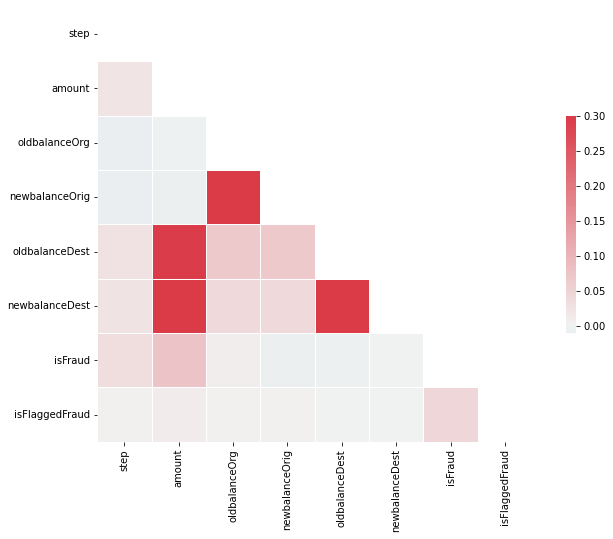

In [5]:
# explore feature correlations
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12,8))

cmap = sns.diverging_palette(220,10,as_cmap=True)

sns.heatmap(corr,mask=mask,cmap=cmap,vmax=.3,center=0,square=True,linewidths=.5,cbar_kws={"shrink":.5})

In [6]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


#### Fraud and Flagged Fraud (> 200 in transaction)
Looks like isFlaggedFraud isn't very helpful

In [8]:
df['agent_type_Orig'] = df['nameOrig'].astype(str).str[0]
df['agent_type_Dest'] = df['nameDest'].astype(str).str[0]

all transactions come from customers and may or may not go to merchants or customers

In [9]:
df.groupby('agent_type_Orig')['step'].count()

agent_type_Orig
C    6362620
Name: step, dtype: int64

In [10]:
df.groupby('agent_type_Dest')['step'].count()

agent_type_Dest
C    4211125
M    2151495
Name: step, dtype: int64

#### Histograms of Data

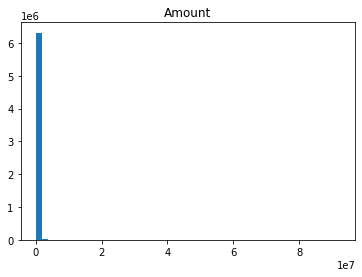

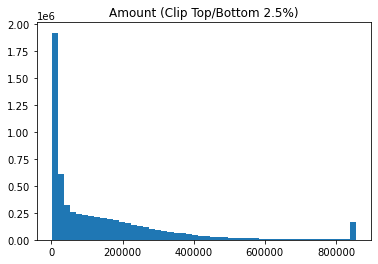

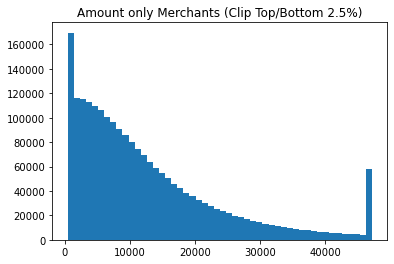

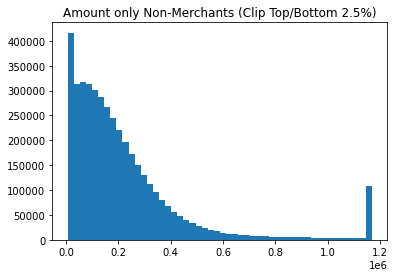

In [11]:
plt.hist(df['amount'], bins=50)
plt.title('Amount')
plt.show()

bot_perc = np.percentile(df['amount'], 2.5)
top_perc = np.percentile(df['amount'], 97.5)
amounts_clip = np.minimum(np.maximum(df['amount'], bot_perc), top_perc)

plt.hist(amounts_clip, bins=50)
plt.title('Amount (Clip Top/Bottom 2.5%)')
plt.show()

type_ = 'M'
bot_perc = np.percentile(df[df['agent_type_Dest'] == type_]['amount'], 2.5)
top_perc = np.percentile(df[df['agent_type_Dest'] == type_]['amount'], 97.5)
amounts_clip = np.minimum(np.maximum(df[df['agent_type_Dest'] == type_]['amount'], bot_perc), top_perc)

plt.hist(amounts_clip, bins=50)
plt.title('Amount only Merchants (Clip Top/Bottom 2.5%)')
plt.show()

type_ = 'C'
bot_perc = np.percentile(df[df['agent_type_Dest'] == type_]['amount'], 2.5)
top_perc = np.percentile(df[df['agent_type_Dest'] == type_]['amount'], 97.5)
amounts_clip = np.minimum(np.maximum(df[df['agent_type_Dest'] == type_]['amount'], bot_perc), top_perc)

plt.hist(amounts_clip, bins=50)
plt.title('Amount only Non-Merchants (Clip Top/Bottom 2.5%)')
plt.show()

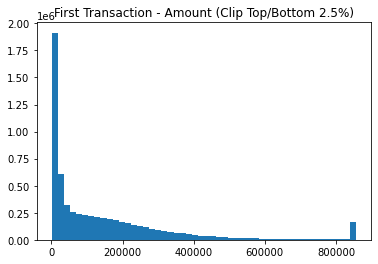

In [12]:
first_transaction = df.groupby('nameOrig')['step'].min().reset_index()
first_transaction = first_transaction.merge(
    df,
    how='inner',
    on=['nameOrig','step']
)

bot_perc = np.percentile(first_transaction['amount'], 2.5)
top_perc = np.percentile(first_transaction['amount'], 97.5)
amounts_clip = np.minimum(np.maximum(first_transaction['amount'], bot_perc), top_perc)

plt.hist(amounts_clip, bins=50)
plt.title('First Transaction - Amount (Clip Top/Bottom 2.5%)')
plt.show()


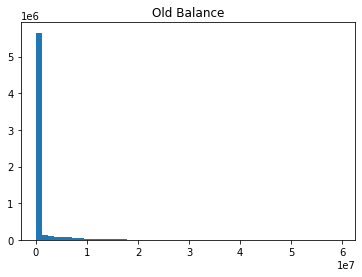

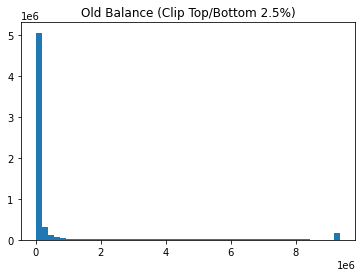

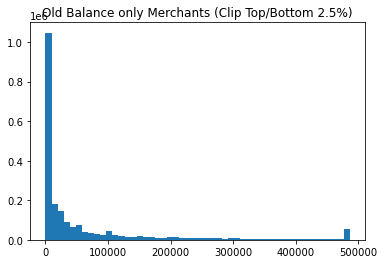

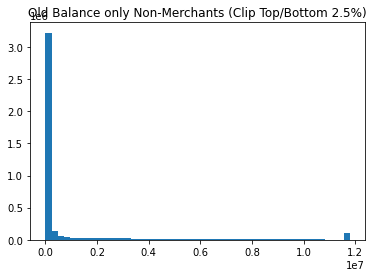

In [13]:
plt.hist(df['oldbalanceOrg'], bins=50)
plt.title('Old Balance')
plt.show()

bot_perc = np.percentile(df['oldbalanceOrg'], 2.5)
top_perc = np.percentile(df['oldbalanceOrg'], 97.5)
amounts_clip = np.minimum(np.maximum(df['oldbalanceOrg'], bot_perc), top_perc)

plt.hist(amounts_clip, bins=50)
plt.title('Old Balance (Clip Top/Bottom 2.5%)')
plt.show()

type_ = 'M'
bot_perc = np.percentile(df[df['agent_type_Dest'] == type_]['oldbalanceOrg'], 2.5)
top_perc = np.percentile(df[df['agent_type_Dest'] == type_]['oldbalanceOrg'], 97.5)
amounts_clip = np.minimum(np.maximum(df[df['agent_type_Dest'] == type_]['oldbalanceOrg'], bot_perc), top_perc)

plt.hist(amounts_clip, bins=50)
plt.title('Old Balance only Merchants (Clip Top/Bottom 2.5%)')
plt.show()

type_ = 'C'
bot_perc = np.percentile(df[df['agent_type_Dest'] == type_]['oldbalanceOrg'], 2.5)
top_perc = np.percentile(df[df['agent_type_Dest'] == type_]['oldbalanceOrg'], 97.5)
amounts_clip = np.minimum(np.maximum(df[df['agent_type_Dest'] == type_]['oldbalanceOrg'], bot_perc), top_perc)

plt.hist(amounts_clip, bins=50)
plt.title('Old Balance only Non-Merchants (Clip Top/Bottom 2.5%)')
plt.show()

#### Fraud and Flagged Fraud (> 200 in transaction)
Looks like isFlaggedFraud isn't very helpful

In [14]:
display(df.groupby('isFraud')['step'].count().reset_index())
display(df.groupby('isFlaggedFraud')['step'].count().reset_index())
display(df.groupby(['isFraud','isFlaggedFraud'])['step'].count().reset_index())
display(df.groupby(['isFraud','agent_type_Dest'])['step'].count().reset_index())


,isFraud,step
0,0,6354407
1,1,8213


,isFlaggedFraud,step
0,0,6362604
1,1,16


,isFraud,isFlaggedFraud,step
0,0,0,6354407
1,1,0,8197
2,1,1,16


,isFraud,agent_type_Dest,step
0,0,C,4202912
1,0,M,2151495
2,1,C,8213


#### Fraud vs Other Features

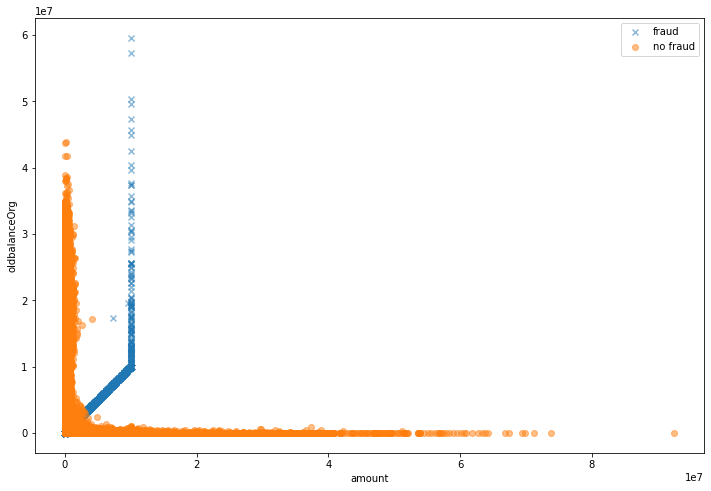

In [61]:
fraud_df = df[df['isFraud'] == 1]
nofraud_df = df[df['isFraud'] == 0]

X = 'amount'
Y = 'oldbalanceOrg'

plt.figure(figsize=(12,8))
plt.scatter(fraud_df[X], fraud_df[Y], alpha = 0.5, marker = 'x', label = 'fraud')
plt.scatter(nofraud_df[X], nofraud_df[Y], alpha = 0.5, marker = 'o', label = 'no fraud')
plt.legend()
plt.xlabel(X)
plt.ylabel(Y)
plt.show()

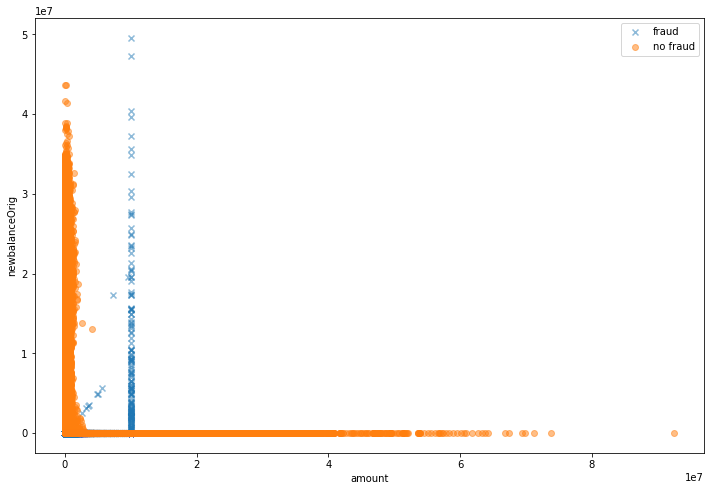

In [64]:
X = 'amount'
Y = 'newbalanceOrig'

plt.figure(figsize=(12,8))
plt.scatter(fraud_df[X], fraud_df[Y], alpha = 0.5, marker = 'x', label = 'fraud')
plt.scatter(nofraud_df[X], nofraud_df[Y], alpha = 0.5, marker = 'o', label = 'no fraud')
plt.legend()
plt.xlabel(X)
plt.ylabel(Y)
plt.show()

#### Number of Repeat Customers

nameOrig
C1065307291    3
C1784010646    3
C1902386530    3
C1832548028    3
C545315117     3
              ..
C1645325210    1
C1645325020    1
C1645324530    1
C1645324143    1
C999999784     1
Name: step, Length: 6353307, dtype: int64

<AxesSubplot:>

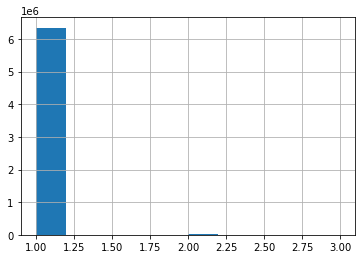

In [10]:
display(df.groupby('nameOrig')['step'].count().sort_values(ascending=False))
df.groupby('nameOrig')['step'].count().reset_index()['step'].hist()

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C1789550256     99
C451111351      99
C1360767589     98
C1023714065     97
C97730845       96
C977993101      96
C392292416      95
C1899073220     92
C306206744      91
C1782113663     90
C1234776885     90
C998351292      89
C716083600      89
C909295153      88
C1674899618     86
C667346055      86
C1262822392     85
C1816757085     84
C1255024717     84
C453211571      84
C2006081398     83
C932583850      82
C1504109395     82
C991363637      82
C1303868418     81
C728526866      81
C1870252780     80
C1883840933     80
C214774813      80
C11003494       80
C1721246982     80
C1909597726     80
C33524623       80
C766681183      80
C1167066016     79
C662736689      79
C769342184      78
C423580937      77
C803116137      77
C1297685781     76
C1850180796     76
C1730752455     76
C863811613      75
C914293025      75
C2049813033     75
C1220897602     74
C17

<AxesSubplot:>

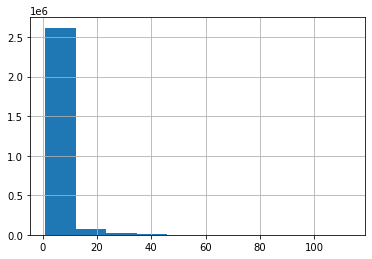

In [11]:
display(df.groupby('nameDest')['step'].count().sort_values(ascending=False).head(60))
df.groupby('nameDest')['step'].count().reset_index()['step'].hist()

#### Transactions Through Time by Type
Is fraud more likely at certain times? Data is based on hourly snapshots.

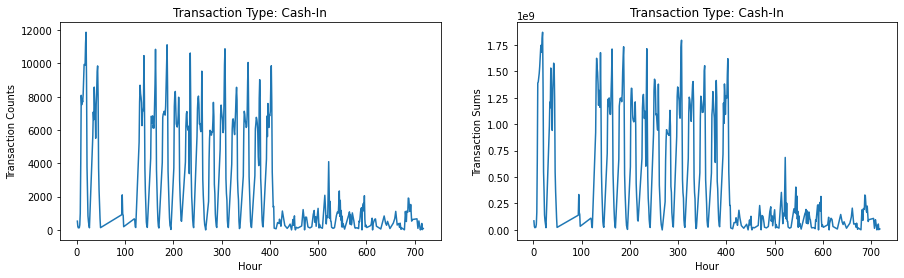

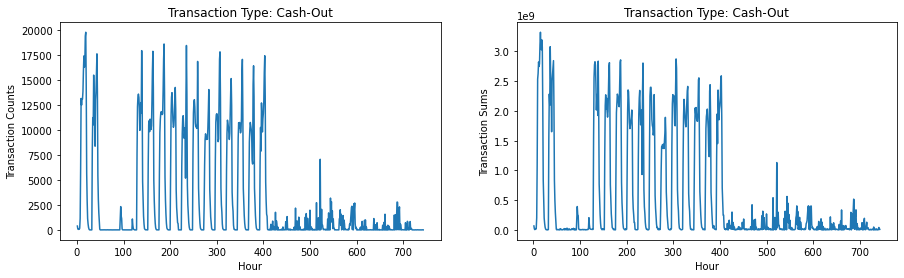

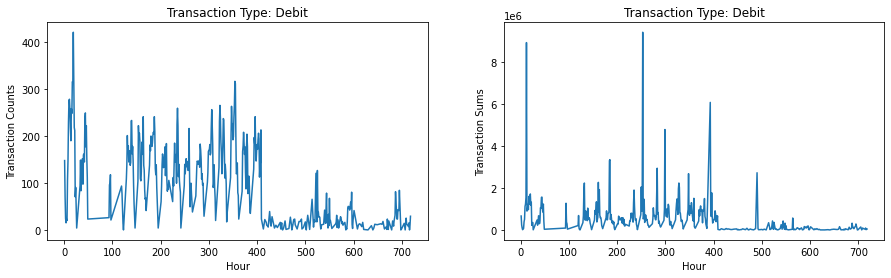

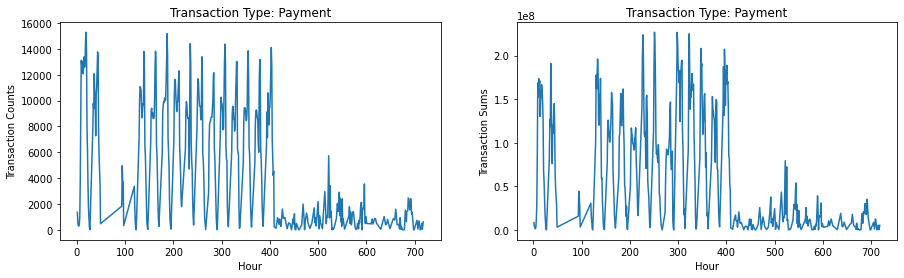

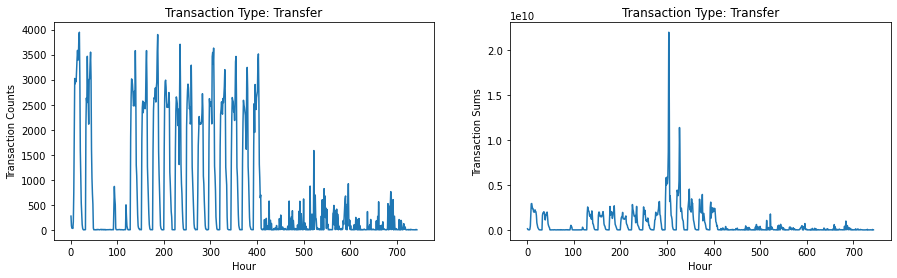

In [8]:
type_dict = {
    'CASH_IN': 'Cash-In',
    'CASH_OUT': 'Cash-Out',
    'DEBIT': 'Debit',
    'PAYMENT': 'Payment',
    'TRANSFER': 'Transfer',
}

data_through_time_count = df.groupby(['step','type'])['amount'].count().reset_index()
data_through_time_sum = df.groupby(['step','type'])['amount'].sum().reset_index()

data_through_time_fraud = df.groupby(['step','type'])['isFraud'].sum().reset_index()

for type_ in pd.unique(data_through_time_count['type']):
    tmp_count = data_through_time_count[data_through_time_count['type'] == type_]
    tmp_sum = data_through_time_sum[data_through_time_sum['type'] == type_]
    
    type_name = type_dict.get(type_)
    
    plt.figure(figsize=(15,4))
    
    plt.subplot(1, 2, 1)
    plt.plot(tmp_count['step'], tmp_count['amount'])
    plt.ylabel('Transaction Counts')
    plt.xlabel('Hour')
    plt.title(f'Transaction Type: {type_name}')

    plt.subplot(1, 2, 2)
    plt.plot(tmp_sum['step'], tmp_sum['amount'])
    plt.ylabel('Transaction Sums')
    plt.xlabel('Hour')
    plt.title(f'Transaction Type: {type_name}')
    
    plt.show()

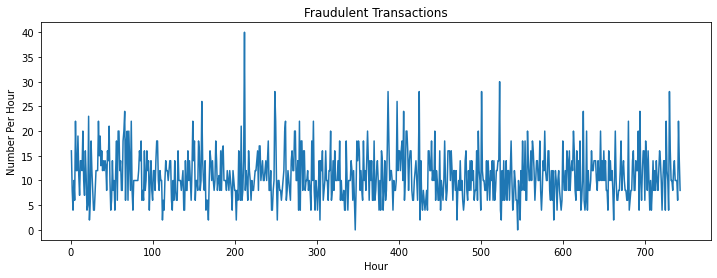

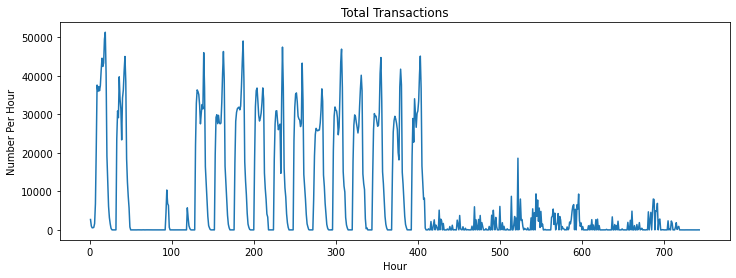

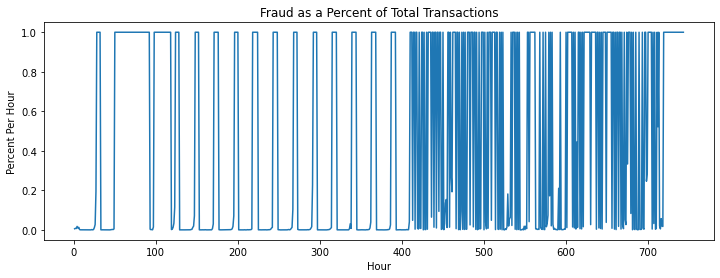

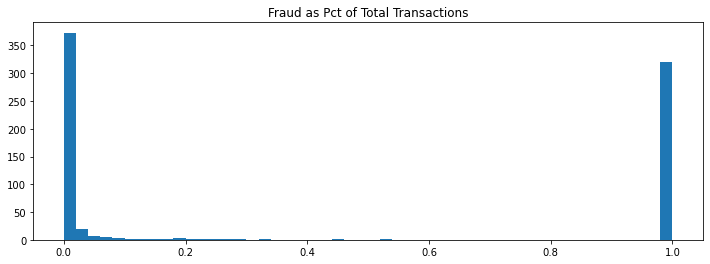

In [11]:
data_through_time_fraud = df.groupby(['step'])['isFraud'].sum().reset_index()
data_through_time_pct_transactions = df.groupby(['step'])['isFraud'].count().reset_index()
data_through_time_pct_transactions = data_through_time_pct_transactions.rename(columns={'isFraud': 'total_transactions'})

data_through_time_pct_transactions = data_through_time_pct_transactions.merge(
    data_through_time_fraud,
    how='left',
    on='step'
)
data_through_time_pct_transactions['isFraud_pct'] = data_through_time_pct_transactions['isFraud']/data_through_time_pct_transactions['total_transactions']

plt.figure(figsize=(12,4))
plt.plot(data_through_time_fraud['step'], data_through_time_fraud['isFraud'])
plt.ylabel('Number Per Hour')
plt.xlabel('Hour')
plt.title('Fraudulent Transactions')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(data_through_time_pct_transactions['step'], data_through_time_pct_transactions['total_transactions'])
plt.ylabel('Number Per Hour')
plt.xlabel('Hour')
plt.title('Total Transactions')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(data_through_time_pct_transactions['step'], data_through_time_pct_transactions['isFraud_pct'])
plt.ylabel('Percent Per Hour')
plt.xlabel('Hour')
plt.title('Fraud as a Percent of Total Transactions')
plt.show()

plt.figure(figsize=(12,4))
plt.hist(data_through_time_pct_transactions['isFraud_pct'],bins = 50)
plt.title('Fraud as Pct of Total Transactions')
plt.show()


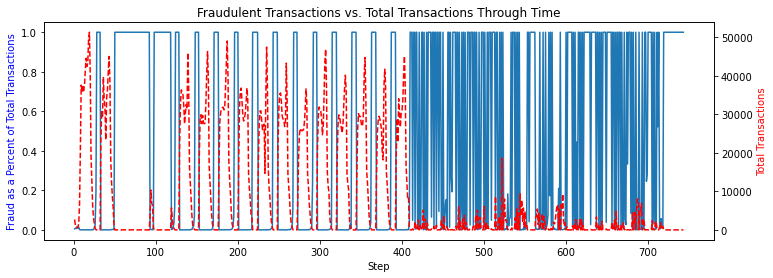

In [12]:
fig, ax1 = plt.subplots(figsize=(12,4))

ax2 = ax1.twinx()
ax1.plot(data_through_time_pct_transactions['step'], data_through_time_pct_transactions['isFraud_pct'])
ax2.plot(data_through_time_pct_transactions['step'], data_through_time_pct_transactions['total_transactions'], linestyle='dashed', color = 'r')

ax1.set_xlabel('Step')
ax1.set_ylabel('Fraud as a Percent of Total Transactions', color = 'blue')
ax2.set_ylabel('Total Transactions', color = 'red')

plt.title('Fraudulent Transactions vs. Total Transactions Through Time')
plt.show()

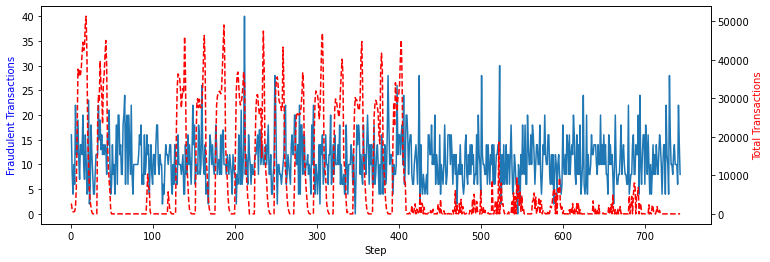

In [18]:
fig, ax1 = plt.subplots(figsize=(12,4))

ax2 = ax1.twinx()
ax1.plot(data_through_time_pct_transactions['step'], data_through_time_pct_transactions['isFraud'])
ax2.plot(data_through_time_pct_transactions['step'], data_through_time_pct_transactions['total_transactions'], linestyle='dashed', color = 'r')

ax1.set_xlabel('Step')
ax1.set_ylabel('Fraudulent Transactions', color = 'blue')
ax2.set_ylabel('Total Transactions', color = 'red')

plt.show()

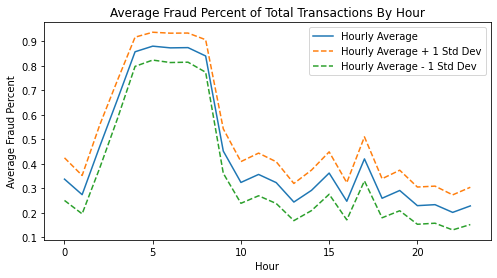

In [17]:
data_through_time_pct_transactions['step_mod'] = data_through_time_pct_transactions['step']%24

data_by_hour = data_through_time_pct_transactions.groupby('step_mod')['isFraud_pct'].mean().reset_index()
data_by_hour_std = data_through_time_pct_transactions.groupby('step_mod')['isFraud_pct'].std().reset_index()
data_by_hour_std = data_by_hour_std.rename(columns={'isFraud_pct':'isFraud_pct_std'})

data_by_hour_count = data_through_time_pct_transactions.groupby('step_mod')['isFraud_pct'].count().reset_index()
data_by_hour_count = data_by_hour_count.rename(columns={'isFraud_pct':'isFraud_pct_count'})

data_by_hour = data_by_hour.merge(
    data_by_hour_std,
    how='inner',
    on='step_mod'
)

data_by_hour = data_by_hour.merge(
    data_by_hour_count,
    how='inner',
    on='step_mod'
)

data_by_hour['isFraud_pct_1stdMore'] = data_by_hour['isFraud_pct'] + data_by_hour['isFraud_pct_std']/data_by_hour['isFraud_pct_count']**0.5
data_by_hour['isFraud_pct_1stdLess'] = data_by_hour['isFraud_pct'] - data_by_hour['isFraud_pct_std']/data_by_hour['isFraud_pct_count']**0.5

plt.figure(figsize=(8,4))
plt.plot(data_by_hour['step_mod'], data_by_hour['isFraud_pct'], label = 'Hourly Average')
plt.plot(data_by_hour['step_mod'], data_by_hour['isFraud_pct_1stdMore'], linestyle='dashed', label = 'Hourly Average + 1 Std Dev')
plt.plot(data_by_hour['step_mod'], data_by_hour['isFraud_pct_1stdLess'], linestyle='dashed', label = 'Hourly Average - 1 Std Dev')
plt.title('Average Fraud Percent of Total Transactions By Hour')
plt.xlabel('Hour')
plt.ylabel('Average Fraud Percent')
plt.legend()
plt.show()

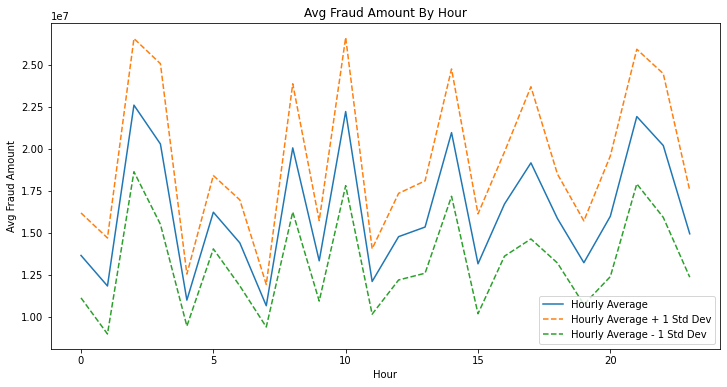

In [102]:
data_through_time_fraud_amt = df[df['isFraud']==1].groupby(['step'])['amount'].sum().reset_index()
data_through_time_fraud_amt['step_mod'] = data_through_time_fraud_amt['step']%24

data_by_hour = data_through_time_fraud_amt.groupby('step_mod')['amount'].mean().reset_index()
data_by_hour_std = data_through_time_fraud_amt.groupby('step_mod')['amount'].std().reset_index()
data_by_hour_std = data_by_hour_std.rename(columns={'amount':'amount_std'})

data_by_hour_count = data_through_time_fraud_amt.groupby('step_mod')['amount'].count().reset_index()
data_by_hour_count = data_by_hour_count.rename(columns={'amount':'amount_count'})

data_by_hour = data_by_hour.merge(
    data_by_hour_std,
    how='inner',
    on='step_mod'
)

data_by_hour = data_by_hour.merge(
    data_by_hour_count,
    how='inner',
    on='step_mod'
)

data_by_hour['amount_1stdMore'] = data_by_hour['amount'] + data_by_hour['amount_std']/data_by_hour['amount_count']**0.5
data_by_hour['amount_1stdLess'] = data_by_hour['amount'] - data_by_hour['amount_std']/data_by_hour['amount_count']**0.5

plt.figure(figsize=(12,6))
plt.plot(data_by_hour['step_mod'], data_by_hour['amount'], label = 'Hourly Average')
plt.plot(data_by_hour['step_mod'], data_by_hour['amount_1stdMore'], linestyle='dashed', label = 'Hourly Average + 1 Std Dev')
plt.plot(data_by_hour['step_mod'], data_by_hour['amount_1stdLess'], linestyle='dashed', label = 'Hourly Average - 1 Std Dev')
plt.title('Avg Fraud Amount By Hour')
plt.xlabel('Hour')
plt.ylabel('Avg Fraud Amount')
plt.legend()
plt.show()

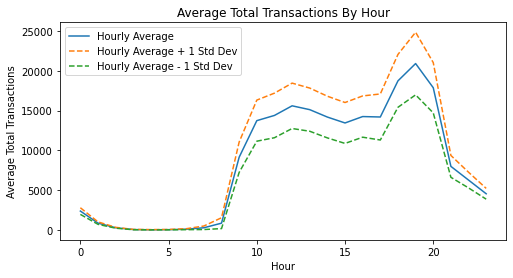

In [18]:
data_through_time_pct_transactions['step_mod'] = data_through_time_pct_transactions['step']%24

data_by_hour = data_through_time_pct_transactions.groupby('step_mod')['total_transactions'].mean().reset_index()
data_by_hour_std = data_through_time_pct_transactions.groupby('step_mod')['total_transactions'].std().reset_index()
data_by_hour_std = data_by_hour_std.rename(columns={'total_transactions':'total_transactions_std'})

data_by_hour_count = data_through_time_pct_transactions.groupby('step_mod')['total_transactions'].count().reset_index()
data_by_hour_count = data_by_hour_count.rename(columns={'total_transactions':'total_transactions_count'})

data_by_hour = data_by_hour.merge(
    data_by_hour_std,
    how='inner',
    on='step_mod'
)

data_by_hour = data_by_hour.merge(
    data_by_hour_count,
    how='inner',
    on='step_mod'
)

data_by_hour['total_transactions_1stdMore'] = data_by_hour['total_transactions'] + data_by_hour['total_transactions_std']/data_by_hour['total_transactions_count']**0.5
data_by_hour['total_transactions_1stdLess'] = data_by_hour['total_transactions'] - data_by_hour['total_transactions_std']/data_by_hour['total_transactions_count']**0.5

plt.figure(figsize=(8,4))
plt.plot(data_by_hour['step_mod'], data_by_hour['total_transactions'], label = 'Hourly Average')
plt.plot(data_by_hour['step_mod'], data_by_hour['total_transactions_1stdMore'], linestyle='dashed', label = 'Hourly Average + 1 Std Dev')
plt.plot(data_by_hour['step_mod'], data_by_hour['total_transactions_1stdLess'], linestyle='dashed', label = 'Hourly Average - 1 Std Dev')
plt.title('Average Total Transactions By Hour')
plt.xlabel('Hour')
plt.ylabel('Average Total Transactions')
plt.legend()
plt.show()

Number of fraudulent transactions is not stationary through time, so we can't use an AR model to predict number of fraudulent transactions in the next time step.

In [74]:
from statsmodels.tsa.stattools import adfuller

X = data_through_time_pct_transactions['isFraud'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
X_diff = X[1:] - X[:-1]
result = adfuller(X_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
X_diff_diff = X_diff[1:] - X_diff[:-1]
result = adfuller(X_diff_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
X_diff_diff_diff = X_diff_diff[1:] - X_diff_diff[:-1]
result = adfuller(X_diff_diff_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -26.592651
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -10.471360
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
ADF Statistic: -11.688443
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
ADF Statistic: -14.629030
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


In [56]:
standardize = True
data = X
p = 1

scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, 1))

y = data[p:]
x = []
for i in range(p):
    x.append(data[(p-i-1):(-i-1)].reshape(data[(p-i-1):(-i-1)].shape[0],))

x = np.array(x).T

x = sm.add_constant(x)

x_train = x
y_train = y

model = sm.OLS(y_train, x_train).fit()

bic = model.bic
r_sq = model.rsquared
r_sq_adj = model.rsquared_adj


In [57]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     -0.001   
Dependent Variable: y                AIC:                2109.3268
Date:               2022-11-08 14:48 BIC:                2118.5455
No. Observations:   742              Log-Likelihood:     -1052.7  
Df Model:           1                F-statistic:        0.3953   
Df Residuals:       740              Prob (F-statistic): 0.530    
R-squared:          0.001            Scale:              1.0022   
--------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
--------------------------------------------------------------------
const       -0.0014     0.0368   -0.0368   0.9706   -0.0735   0.0708
x1           0.0231     0.0367    0.6287   0.5297   -0.0490   0.0952
------------------------------------------------------------------
Omnibus:             109.606       Durbin-Watson:          1.995  
Prob(Omnibus):       0.000         Jarque-Bera (JB):       200.904
Skew:                0.892         Prob(JB):               0.000  
Kurtosis:            4.822         Condition No.:          1      
==================================================================

"""

In [58]:
X = data_through_time_pct_transactions['isFraud_pct'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
X_diff = X[1:] - X[:-1]
result = adfuller(X_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
X_diff_diff = X_diff[1:] - X_diff[:-1]
result = adfuller(X_diff_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
X_diff_diff_diff = X_diff_diff[1:] - X_diff_diff[:-1]
result = adfuller(X_diff_diff_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.094247
p-value: 0.026982
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
ADF Statistic: -14.060357
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
ADF Statistic: -13.383650
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
ADF Statistic: -13.893762
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


In [85]:
X = data_through_time_pct_transactions['isFraud']

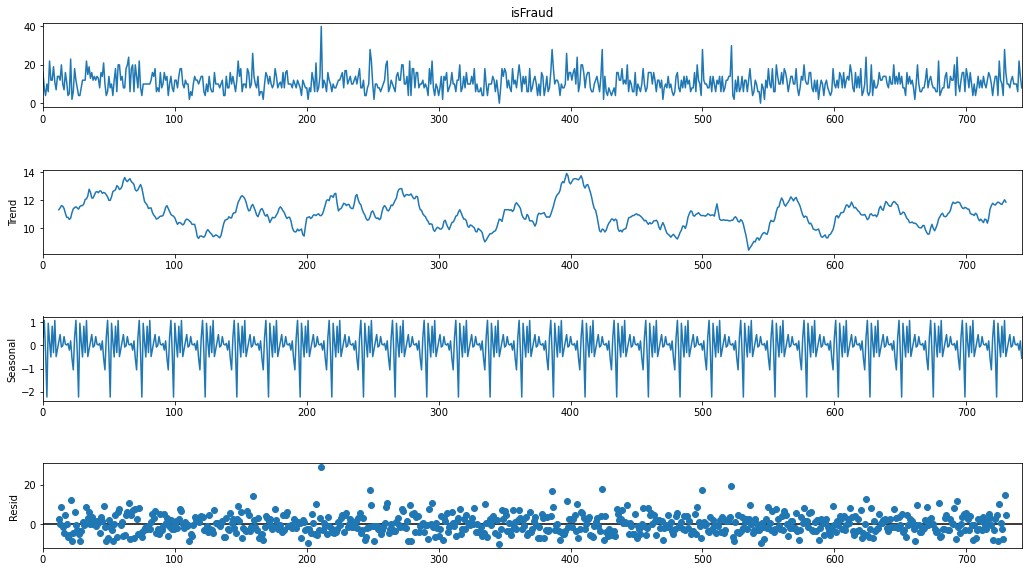

In [96]:
from statsmodels.tsa.seasonal import seasonal_decompose
X = data_through_time_pct_transactions['isFraud']
result = seasonal_decompose(X, period = 24)
fig = result.plot()
fig.set_size_inches((16, 9))
plt.show()

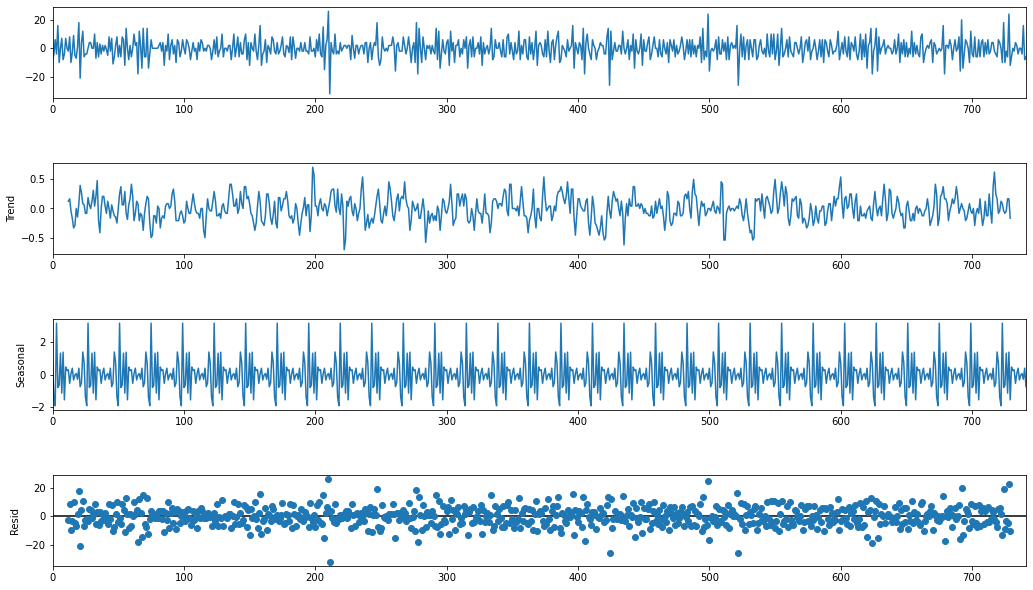

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose
X = data_through_time_pct_transactions['isFraud']
X = pd.Series(X.values[1:] - X.values[:-1])
result = seasonal_decompose(X, period = 24)
fig = result.plot()
fig.set_size_inches((16, 9))
plt.show()